In [0]:
import sys
ruta_principal = '/Workspace/Users/clara.trujillosantosolmo@emeal.nttdata.com/.ide/ml-recommender-data-gen-14982321'
sys.path.insert(0, ruta_principal)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.io_utils import save_file_to_format, read_file_in_format
input_format="parquet"

In [0]:
# Configuración de la conexión JDBC
def read_from_sql_server(schema, table_name):

    df = spark.read.format("jdbc") \
        .option("url", dbutils.secrets.get("mahou", "sqlserver-connection-string")) \
        .option("dbtable", f"{schema}.{table_name}") \
        .option("user", 'mahouadmin') \
        .option("password", 'Password1234!') \
        .load()

    return df.toPandas()

In [0]:
maestro_cliente_path="/dbfs/mnt/MSM/cleaned_data/maestro_cliente_final_12UM.parquet"
maestro_clientes=read_file_in_format(maestro_cliente_path, format=input_format)

In [0]:
order_detail = read_from_sql_server(
"ms_cart"
,
"OrdersDetail"
)

In [0]:
order_detail['CouponDescription'].unique()

array([None, '', '15%dcto.compraonline.MERECES15',
       '15€3comp.on.Com>150€.nuevo', '10%compraonlinevuelve.on.Max.500€',
       '20€dcto.compraonline.Primavera20E',
       '10%dcto.compraonline.FINAL10E', '15€dcto.compraonline.Fallas15',
       '20% 1ªcom.on.Max.500€', '15%seg.compra.max500.nuevo',
       '10%dcto.compraonline.SanValentin.Historias10',
       '10€4ªcomp.on.Comp.>150€.nuevo', '20€dcto.tarjetaregalo.Regalo20',
       '20%dcto.compraonline.Pascua20',
       'Descuento E-commerce SANPATRICIO15E',
       '15€dcto.compraonline.SanPatricio15E',
       'Descuento E-commerce HISTORIAS10', '20240321-UAT10',
       'Descuento E-commerce AÑONUEVO15', 'VOLDIS15%', 'VOLDIS15E',
       'BIENVENIDA20', 'Descuento E-commerce NAVIBAR20', 'Barroja100€',
       'VOLDIS10E', 'Descuento E-commerce HAPPY10'], dtype=object)

# Feature Engineering

###Filtros

In [0]:
order_detail['CouponId'] = order_detail['CouponId'].replace('', pd.NA)
order_detail['CouponId'].fillna(pd.NA, inplace=True)



In [0]:
order_detail['CouponDiscountPct'] = order_detail['CouponDiscountPct'].replace([None, ''], 0)

Pdvs que al menos han usado cupon alguna vez

In [0]:
df_filtered = order_detail[order_detail['CouponId'].notna()]

pdvs_con_cupon = df_filtered['PointOfSaleId'].unique()


In [0]:
pdvs_con_cupon

array(['61529', '67574', '68300', ..., '60473', 'CLI0032498',
       'CLI0048957'], dtype=object)

In [0]:
df_filtrado = order_detail[order_detail['PointOfSaleId'].isin(pdvs_con_cupon)]


In [0]:
df_filtrado['CouponId'].unique()

array([<NA>, 'RB-0000000047', 'RB-0000000016', 'RB-00000000027',
       'RB-0000000045', 'RB-0000000046', 'RB-0000000043B',
       'RB-0000000001', 'RB-0000000046B', 'RB-0000000015',
       'RB-0000000041B', 'RB-0000000017', 'tarjeta-regalo-20',
       'RB-0000000045B', 'RB-0000000044B', 'RB-0000000044',
       'RB-0000000042', 'RB-0000000047B', 'RB-0000000042B',
       'RB-0000000100', 'RB-0000000009', 'RB-0000000102', 'RB-0000000101',
       '20240321-UAT10', 'RB-0000000040', 'RB-0000000041',
       'RB-0000000038B', 'RB-0000000038', 'RB-00BARROJA',
       'RB-0000000039B', 'RB-0000000040B'], dtype=object)

In [0]:

df_filtrado_selected=df_filtrado[['OrderId','DistributorID','CodeDistributor','Name','NameDistributor','PointOfSaleId','CouponId','CouponMax','CouponCode','CouponDescription','OrderDate','CouponDiscountAmt','CouponDiscountPct','Amount','CodeProduct','TotalPrice']]

In [0]:
#Productos con cupones 
df_filtrado_selected['CodeProduct'].nunique()

2941

In [0]:
df_filtrado_selected['CouponId'].unique()

array([<NA>, 'RB-0000000047', 'RB-0000000016', 'RB-00000000027',
       'RB-0000000045', 'RB-0000000046', 'RB-0000000043B',
       'RB-0000000001', 'RB-0000000046B', 'RB-0000000015',
       'RB-0000000041B', 'RB-0000000017', 'tarjeta-regalo-20',
       'RB-0000000045B', 'RB-0000000044B', 'RB-0000000044',
       'RB-0000000042', 'RB-0000000047B', 'RB-0000000042B',
       'RB-0000000100', 'RB-0000000009', 'RB-0000000102', 'RB-0000000101',
       '20240321-UAT10', 'RB-0000000040', 'RB-0000000041',
       'RB-0000000038B', 'RB-0000000038', 'RB-00BARROJA',
       'RB-0000000039B', 'RB-0000000040B'], dtype=object)

In [0]:
# Agrupar por orderID, companyID y fecha
order_detail_grouped = df_filtrado_selected.groupby(['OrderId', 'DistributorID', 'OrderDate']).agg({
    'CodeProduct': lambda x: list(x),
    'TotalPrice': 'sum',
    'Amount':'sum'
}).reset_index()



In [0]:
import pandas as pd
columns_to_keep = [
    'OrderId', 'DistributorID','CouponId' ,'OrderDate', 'Name', 'NameDistributor', 
    'PointOfSaleId','CouponDiscountAmt','CouponDiscountPct','CouponMax','CouponDescription'
]
other_columns = df_filtrado_selected[columns_to_keep].drop_duplicates()
#DF final
order_detail_final = pd.merge(order_detail_grouped, other_columns, on=['OrderId', 'DistributorID', 'OrderDate'], how='left')

order_detail_sorted = order_detail_final.sort_values(by=['OrderId', 'OrderDate','Name'])

In [0]:
order_detail_sorted[order_detail_sorted['OrderId']=='0008143AA702312306B848F7EE5801B8']

,OrderId,DistributorID,OrderDate,CodeProduct,TotalPrice,Amount,CouponId,Name,NameDistributor,PointOfSaleId,CouponDiscountAmt,CouponDiscountPct,CouponMax,CouponDescription
3,0008143AA702312306B848F7EE5801B8,7E27D492-A885-4DC3-939E-AB718B667C8B,2024-06-20T00:00:00,"[042, 06, 23, 51, LOG, 511]",139.37,11,<NA>,CHARLY - CAFETERIA,BEBICER,01575,None,0,None,NoCupon


### Tipología punto de venta

In [0]:
maestro_clientes=maestro_clientes[['tipologia','company_id']]

In [0]:
order_detail_sorted= pd.merge(order_detail_sorted,maestro_clientes, left_on='PointOfSaleId', right_on='company_id',how='left' )
order_detail_sorted.drop(columns='company_id',inplace=True)

####Cálculo de lag por cupones en pedidos ( Sellout y numero de productos)

In [0]:

order_detail_sorted['Coupon_LAG_1'] = order_detail_sorted.groupby('Name')['CouponDiscountAmt'].shift(1)
order_detail_sorted['Coupon_LAG_2'] = order_detail_sorted.groupby('Name')['CouponDiscountAmt'].shift(2)
order_detail_sorted['Coupon_LAG_3'] = order_detail_sorted.groupby('Name')['CouponDiscountAmt'].shift(3)
# order_detail_sorted['Amount_LAG_1'] = order_detail_sorted.groupby('Name')['Amount'].shift(1)
# order_detail_sorted['Amount_LAG_2'] = order_detail_sorted.groupby('Name')['Amount'].shift(2)
# order_detail_sorted['Amount_LAG_3'] = order_detail_sorted.groupby('Name')['Amount'].shift(3)

#### Media moneataria de cupones en pedidos anteriores

In [0]:
order_detail_sorted['OrderDate'] = pd.to_datetime(order_detail_sorted['OrderDate'])

In [0]:
order_detail_sorted=order_detail_sorted.sort_values(by='OrderDate',ascending=True)

In [0]:
order_detail_sorted['CouponDiscountAmt'].replace('', 0, inplace=True)
order_detail_sorted['CouponDiscountAmt'].astype(float)

106724    0.0
105548    0.0
27554     0.0
48997     0.0
9960      0.0
         ... 
69665     0.0
543       0.0
68342     0.0
69961     0.0
68185     0.0
Name: CouponDiscountAmt, Length: 125165, dtype: float64

In [0]:
def calcular_media_monetaria(df):
    df['acumulado'] = df['CouponDiscountAmt'].expanding().sum()
    df['conteo'] = df['CouponDiscountAmt'].expanding().count()
    # df['avg_previous_coupons'] = df['acumulado'] / df['conteo']
    return df


In [0]:

# Aplicar la función a cada grupo de PDV
order_detail_sorted = order_detail_sorted.groupby('PointOfSaleId').apply(calcular_media_monetaria)

/root/.ipykernel/1126/command-4238495784605991-1434040165:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  order_detail_sorted = order_detail_sorted.groupby('PointOfSaleId').apply(calcular_media_monetaria)


In [0]:
#pd.set_option('display.max_rows', None)
order_detail_sorted[order_detail_sorted['Name']=='BAR BARROJA']

,OrderId,DistributorID,OrderDate,CodeProduct,TotalPrice,Amount,CouponId,Name,NameDistributor,PointOfSaleId,CouponDiscountAmt,CouponDiscountPct,CouponMax,CouponDescription,tipologia,Coupon_LAG_1,Coupon_LAG_2,Coupon_LAG_3,acumulado,conteo
90116,BC73C8EA3D04DB3E8D64E8DE1215E07A,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-02 00:00:00,"[PRD0005422, PRD0000618, PRD0005442, PRD000543...",417.47,10,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,1.0
92152,BC73C8EA3D04DB3EA7FD7F8A555F7FAE,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-02 00:00:00,"[PRD0002741, PRD0002730]",-9.28,-58,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,2.0
92622,BC73C8EA3D04DB3EAEE7786C487E021B,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-12 00:00:00,"[PRD0005422, PRD0000457, PRD0005445, PRD000234...",739.66,19,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,3.0
91042,BC73C8EA3D04DB3E99AEAD5A81FB8413,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-16 00:00:00,"[PRD0004350, PRD0005442, PRD0005431, PRD000061...",535.29,14,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,4.0
83964,BC73C8EA3D04DB3E3915E61E1E0619D7,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-16 00:00:00,[PRD0002342],-30.00,-1,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116791,E68E05129C75CC76DEF80C04F8E29B28,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2024-06-27 00:00:00,"[PRD0007246, PRD0007091]",0.00,12,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,50,840.0,280.0
115219,E68E05129C75CC76B52F99B4CAB366DF,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2024-06-27 00:00:00,"[PRD0005468, PRD0005422, PRD0005432, PRD000467...",1678.63,29,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,0,NoCupon,Establecimiento de Tapeo,0,0,0,840.0,281.0
69324,A4076F9F1695635659724855608220E433703CEF35DAABBE,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2024-06-27 12:42:15,"[PRD0010014, PRD0005468, PRD0005432, PRD000538...",1025.63,29,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,0,NoCupon,Establecimiento de Tapeo,0,0,0,840.0,282.0
117543,E68E05129C75CC76F2635D05827F6208,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2024-07-01 00:00:00,"[PRD0005422, PRD0004673, PRD0004347, PRD000062...",1530.43,41,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,840.0,283.0


### Creación variable Cat de cupones

In [0]:
order_detail_sorted['CouponDiscountAmt'].astype('float')


106724    0.0
105548    0.0
27554     0.0
48997     0.0
9960      0.0
         ... 
69665     0.0
543       0.0
68342     0.0
69961     0.0
68185     0.0
Name: CouponDiscountAmt, Length: 125165, dtype: float64

In [0]:
order_detail_sorted['CouponDiscountPct'] = pd.to_numeric(order_detail_sorted['CouponDiscountPct'], errors='coerce')
order_detail_sorted['CouponDiscountPct'].unique()

array([ 0, 15, 20, 10])

In [0]:
order_detail_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125165 entries, 106724 to 68185
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   OrderId            125165 non-null  object        
 1   DistributorID      125165 non-null  object        
 2   OrderDate          125165 non-null  datetime64[ns]
 3   CodeProduct        125165 non-null  object        
 4   TotalPrice         125165 non-null  float64       
 5   Amount             125165 non-null  int64         
 6   CouponId           7248 non-null    object        
 7   Name               125158 non-null  object        
 8   NameDistributor    125165 non-null  object        
 9   PointOfSaleId      125165 non-null  object        
 10  CouponDiscountAmt  125165 non-null  float64       
 11  CouponDiscountPct  125165 non-null  int64         
 12  CouponMax          123724 non-null  object        
 13  CouponDescription  125165 non-null  obje

In [0]:
def clasificar_descuento(row):
    # Verificar si los valores no son nulos
    if pd.notna(row['CouponDiscountAmt']) and pd.notna(row['CouponDiscountPct']) and pd.notna(row['CouponId']):
        if row['CouponDiscountAmt'] != 0 and row['CouponDiscountPct'] == 0:
            return 'Fijo'
        elif row['CouponDiscountPct'] != 0 and row['CouponId'] != 0:
            return 'Porcentual'
        else:
            return 'NoCupon' 
    else:
        return 'NoCupon' 

In [0]:
order_detail_sorted['Coupon_type'] = order_detail_sorted.apply(clasificar_descuento, axis=1)

In [0]:
order_detail_sorted[order_detail_sorted['Coupon_type']=='Porcentual']

,OrderId,DistributorID,OrderDate,CodeProduct,TotalPrice,Amount,CouponId,Name,NameDistributor,PointOfSaleId,CouponDiscountAmt,CouponDiscountPct,CouponMax,CouponDescription,tipologia,Coupon_LAG_1,Coupon_LAG_2,Coupon_LAG_3,acumulado,conteo,Coupon_type
91488,BC73C8EA3D04DB3E9FA8986325D2C696,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-12-18 00:00:00,"[PRD0005697, PRD0001883, PRD0009380, PRD000542...",419.77,13,RB-0000000038,CAFE BELEN,Voldis Madrid BC,CLI0034346,20,0,0,Descuento E-commerce NAVIBAR20,Noche Temprana,0,0,0,20.00,51.0,Porcentual
72891,A7165F8B6E740D812A7302D7CCC2D48D,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-12-18 00:00:00,"[PRD0015885, PRD0012779, PRD0003563, PRD001273...",209.61,18,RB-0000000038,CARRIL,Voldis Madrid BC,CLI0030927,20,0,0,Descuento E-commerce NAVIBAR20,Establecimiento de Tapeo,0,0,0,20.00,59.0,Porcentual
75013,A7165F8B6E740D81801942792BF6F174,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-12-18 00:00:00,"[PRD0005431, PRD0005432]",1134.46,10,RB-0000000038,VELLA-CARDEÑO,Voldis Madrid BC,CLI0030079,20,0,0,Descuento E-commerce NAVIBAR20,Bar Tradicional,0,0,0,20.00,78.0,Porcentual
75409,A7165F8B6E740D818FF2F4D2B2EACAAB,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-12-18 00:00:00,[PRD0005431],304.71,3,RB-0000000038,CARDEÑO II,Voldis Madrid BC,CLI0030589,20,0,0,Descuento E-commerce NAVIBAR20,Restaurante,0,0,0,20.00,34.0,Porcentual
17459,38CE7DABBDFE79F864E403558539A89E6D1921D25396E9B5,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-12-18 00:00:00,"[PRD0004672, PRD0005422, PRD0005421, PRD001217...",-375.17,-13,RB-0000000038,EL RACO,Voldis Madrid BC,CLI0033159,20,0,0,Descuento E-commerce NAVIBAR20,Bar Tradicional,0,0,0,20.00,62.0,Porcentual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,092866B66FF3C5A0AAC82AA8D62699AE529F231DFBD223...,652c6174-39ac-4ca8-b4da-56dac5baf93b,2024-07-03 12:13:08,"[7560, 997023, 997044, 7037, 997005, 996973]",409.32,27,RB-0000000017,HIFI BAR,Voldis Valencia,68602,10,0,0,10€4ªcomp.on.Comp.>150€.nuevo,No Segmentado,8.13,50,NaN,143.13,6.0,Porcentual
71741,A4076F9F16956356F99E6519705E8D197E054FA3DE0D9D...,9cc0bcf9-4378-40a7-b258-a01fbdd9a7e2,2024-07-03 13:02:09,[PRD0005432],169.00,1,RB-0000000017,VILLALOBILLOS,Voldis Madrid BC,CLI0029896,10,0,0,10€4ªcomp.on.Comp.>150€.nuevo,Establecimiento de Tapeo,0,0,0,684.72,108.0,Porcentual
850,092866B66FF3C5A05B037AAAF43ACBFBB5C5702DB81A72...,652c6174-39ac-4ca8-b4da-56dac5baf93b,2024-07-03 13:34:08,"[5650, 2090, 5561]",431.04,29,RB-0000000001,BAR CANTONET,Voldis Valencia,69009,86.21,20,500,20% 1ªcom.on.Max.500€,No Segmentado,NaN,NaN,NaN,86.21,1.0,Porcentual
68523,A4076F9F169563561F9557230C3371317C09B05E30D4B0...,9cc0bcf9-4378-40a7-b258-a01fbdd9a7e2,2024-07-03 13:47:07,"[PRD0005432, PRD0005443]",197.31,6,RB-0000000016,MR. LEMMON PUB,Voldis Madrid BC,CLI0033188,15,0,0,15€3comp.on.Com>150€.nuevo,Noche Temprana,0,0,0,15.00,88.0,Porcentual


# Análisis descriptivo

### Filtro de segmentación de pdvs

Ventas totales por dvs/ cupones usados/ descuento promedio

In [0]:
sales_coupon = order_detail_sorted[order_detail_sorted['CouponId'].notna()].groupby('PointOfSaleId')['TotalPrice'].sum()
total_sales = order_detail_sorted.groupby('PointOfSaleId')['TotalPrice'].sum()
pctg_coupon_used = (sales_coupon / total_sales) * 100

In [0]:
order_detail_sorted['PointOfSaleId'].nunique()

1533

In [0]:
# Mostrar resultados
for pdv_id, porcentaje in pctg_coupon_used.items():
    print(f"PDV {pdv_id}: {porcentaje:.2f}% de uso de cupones en compras totales.")


PDV 01071: 2.33% de uso de cupones en compras totales.
PDV 01076: 13.25% de uso de cupones en compras totales.
PDV 01091: 5.05% de uso de cupones en compras totales.
PDV 01174: 3.40% de uso de cupones en compras totales.
PDV 01227: 28.76% de uso de cupones en compras totales.
PDV 01235: 6.95% de uso de cupones en compras totales.
PDV 01306: 3.92% de uso de cupones en compras totales.
PDV 01375: 2.92% de uso de cupones en compras totales.
PDV 01391: 1.91% de uso de cupones en compras totales.
PDV 01412: 2.01% de uso de cupones en compras totales.
PDV 01533: 7.23% de uso de cupones en compras totales.
PDV 01543: 14.04% de uso de cupones en compras totales.
PDV 01547: 1.58% de uso de cupones en compras totales.
PDV 01559: 17.77% de uso de cupones en compras totales.
PDV 01575: 4.91% de uso de cupones en compras totales.
PDV 01577: 6.94% de uso de cupones en compras totales.
PDV 01583: 1.32% de uso de cupones en compras totales.
PDV 01596: 3.90% de uso de cupones en compras totales.
PDV 01

PDVs con % de uso de cupones >60


In [0]:
contador = 0

# Iterar sobre el diccionario
for pdv_id, porcentaje in pctg_coupon_used.items():
    if porcentaje > 60.0:
        contador += 1
        # print(f"PDV {pdv_id}: {porcentaje:.2f}% de uso de cupones en compras totales.")


In [0]:
#Porcentaje de pdvs sobre total 
(contador/order_detail_sorted['PointOfSaleId'].nunique())*100

17.35159817351598

###Análisis cupones

Cupon máximo

In [0]:
order_detail_sorted[order_detail_sorted['Name']=='BAR BARROJA']

,OrderId,DistributorID,OrderDate,CodeProduct,TotalPrice,Amount,CouponId,Name,NameDistributor,PointOfSaleId,CouponDiscountAmt,CouponDiscountPct,CouponMax,CouponDescription,tipologia,Coupon_LAG_1,Coupon_LAG_2,Coupon_LAG_3,acumulado,conteo,Coupon_type
90116,BC73C8EA3D04DB3E8D64E8DE1215E07A,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-02 00:00:00,"[PRD0005422, PRD0000618, PRD0005442, PRD000543...",417.47,10,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,1.0,NoCupon
92152,BC73C8EA3D04DB3EA7FD7F8A555F7FAE,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-02 00:00:00,"[PRD0002741, PRD0002730]",-9.28,-58,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,2.0,NoCupon
92622,BC73C8EA3D04DB3EAEE7786C487E021B,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-12 00:00:00,"[PRD0005422, PRD0000457, PRD0005445, PRD000234...",739.66,19,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,3.0,NoCupon
91042,BC73C8EA3D04DB3E99AEAD5A81FB8413,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-16 00:00:00,"[PRD0004350, PRD0005442, PRD0005431, PRD000061...",535.29,14,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,4.0,NoCupon
83964,BC73C8EA3D04DB3E3915E61E1E0619D7,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2023-01-16 00:00:00,[PRD0002342],-30.00,-1,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,0.0,5.0,NoCupon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116791,E68E05129C75CC76DEF80C04F8E29B28,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2024-06-27 00:00:00,"[PRD0007246, PRD0007091]",0.00,12,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,50,840.0,280.0,NoCupon
115219,E68E05129C75CC76B52F99B4CAB366DF,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2024-06-27 00:00:00,"[PRD0005468, PRD0005422, PRD0005432, PRD000467...",1678.63,29,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,0,NoCupon,Establecimiento de Tapeo,0,0,0,840.0,281.0,NoCupon
69324,A4076F9F1695635659724855608220E433703CEF35DAABBE,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2024-06-27 12:42:15,"[PRD0010014, PRD0005468, PRD0005432, PRD000538...",1025.63,29,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,0,NoCupon,Establecimiento de Tapeo,0,0,0,840.0,282.0,NoCupon
117543,E68E05129C75CC76F2635D05827F6208,9CC0BCF9-4378-40A7-B258-A01FBDD9A7E2,2024-07-01 00:00:00,"[PRD0005422, PRD0004673, PRD0004347, PRD000062...",1530.43,41,<NA>,BAR BARROJA,Voldis Madrid BC,CLI0034477,0,0,,NoCupon,Establecimiento de Tapeo,0,0,0,840.0,283.0,NoCupon


####  KPIS :
  * Sellout
  * Número de productos comprados

Visión General

In [0]:
order_detail_sorted['CouponDiscountAmt'] = pd.to_numeric(order_detail_sorted['CouponDiscountAmt'], errors='coerce').fillna(0)
kpis_por_pdv_promo = order_detail_sorted.groupby(['PointOfSaleId', 'CouponId']).agg(
    impacto_promociones=pd.NamedAgg(column='CouponDiscountAmt', aggfunc='sum'), #impacto monetario por cupones aplicados por PDV y promo
    total_productos_comprados=pd.NamedAgg(column='Amount', aggfunc='sum') # total de la cantidad de productos comprados por cada PDV
).reset_index()

In [0]:
kpis_por_pdv_promo.sort_values('impacto_promociones',ascending=False)

,PointOfSaleId,CouponId,impacto_promociones,total_productos_comprados
3573,CLI0043317,RB-0000000044B,400.00,71
109,06619,RB-0000000001,352.85,60
1826,CLI0026765,RB-0000000044B,305.20,88
2589,CLI0029844,RB-0000000047,300.00,76
2249,CLI0028111,RB-0000000047,296.64,313
...,...,...,...,...
1117,68510,RB-0000000047,1.87,2
1021,67808,RB-0000000046,1.82,1
383,50946,RB-0000000046,1.81,1
336,4472,RB-0000000047,1.20,1


#### Distribución de pedidos por pdv

In [0]:
# 50 PDVs con más pedidos
top_pdvs = order_detail_sorted['PointOfSaleId'].value_counts().nlargest(50).index.tolist()


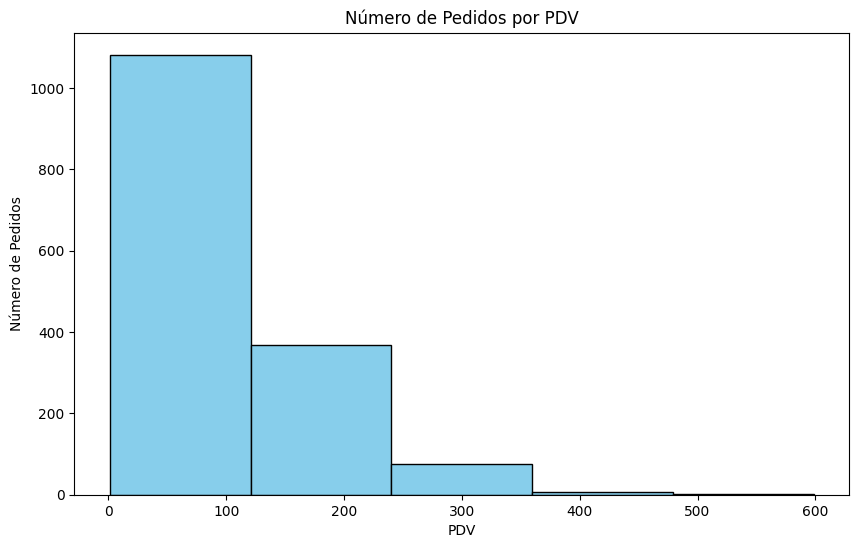

In [0]:

pedidos_por_pdv = order_detail_sorted['PointOfSaleId'].value_counts()

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(pedidos_por_pdv, bins=5, color='skyblue', edgecolor='black')
plt.title('Número de Pedidos por PDV')
plt.xlabel('PDV')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=0)
plt.show()
